<a href="https://colab.research.google.com/github/honyango/test/blob/main/SPARK_MAPREDUCE_EDA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--2025-09-28 16:47:14--  https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘titanic.csv.1’

titanic.csv.1       100%[===================>]  58.89K  --.-KB/s    in 0.02s   

2025-09-28 16:47:15 (3.20 MB/s) - ‘titanic.csv.1’ saved [60302/60302]



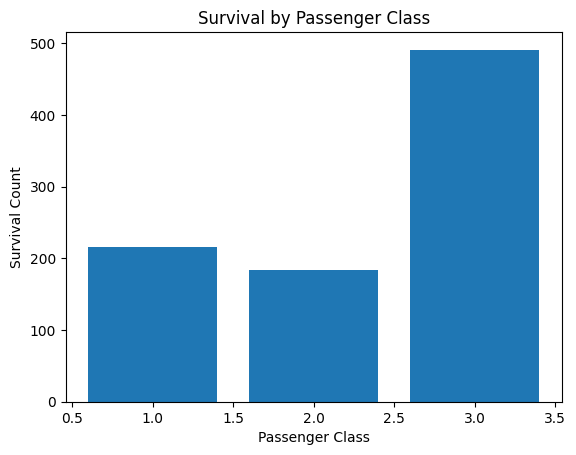

Filtered Data (Survived Adults):
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| NULL|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          9|       1|     3|Johnson, Mrs. Osc...|female|27.0|    0|    2|          347742|11.1333| NULL|       S|
|         12|       1|     1|Bonnell, Miss. El...|female|58.0|    0|    0|          113783|  26.55| C103|       S|
+-----------+--------+------+------------------

In [4]:
# Cell 1: Install dependencies
!apt-get install openjdk-8-jdk-headless -qq > /dev/null  # Install Java
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz  # Download Spark
!tar xf spark-3.5.0-bin-hadoop3.tgz  # Extract
!pip install -q findspark pyspark  # Install PySpark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

import findspark
findspark.init()

# Cell 2: Download dataset
!wget https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv

# Cell 3: Spark code execution
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, count
import matplotlib.pyplot as plt
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Titanic Data Processing") \
    .master("local[*]") \
    .getOrCreate()

# Load data
df = spark.read.csv("titanic.csv", header=True, inferSchema=True)

# Filtering: Survived adults (age > 18)
filtered_df = df.filter((df['Survived'] == 1) & (df['Age'] > 18))

# Aggregation: Group by Pclass and Sex, compute avg Age/Fare and count
agg_df = df.groupBy('Pclass', 'Sex').agg(
    avg('Age').alias('Avg_Age'),
    avg('Fare').alias('Avg_Fare'),
    count('*').alias('Count')
)

# EDA: Summary statistics
summary = df.describe(['Age', 'Fare', 'Survived'])

# Convert to Pandas for plotting (simple bar chart: Survival by Class)
pandas_df = df.groupBy('Pclass').agg(count('Survived').alias('Survival_Count')).toPandas()
plt.bar(pandas_df['Pclass'], pandas_df['Survival_Count'])
plt.xlabel('Passenger Class')
plt.ylabel('Survival Count')
plt.title('Survival by Passenger Class')
plt.show()

# Show results
print("Filtered Data (Survived Adults):")
filtered_df.show(5)

print("Aggregated Data:")
agg_df.show()

print("EDA Summary:")
summary.show()

# Stop Spark session
spark.stop()

MAP REDUCE

In [7]:
# Cell 1: Install mrjob
!pip install mrjob

# Cell 2: Download dataset (if not already done)
!wget https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv

# Cell 3: Write MapReduce script to a file
%%writefile titanic_mr.py
from mrjob.job import MRJob, MRStep
import csv

class TitanicMR(MRJob):

    def steps(self):
        return [
            MRStep(mapper=self.mapper, reducer=self.reducer)
        ]

    def mapper(self, _, line):
        # Parse CSV line (skip header)
        row = next(csv.reader([line]))
        if row[0] == 'PassengerId':  # Skip header
            return
        survived = int(row[1])
        pclass = int(row[2])
        sex = row[5]
        age = float(row[6]) if row[6] else 0  # Handle missing age
        fare = float(row[9]) if row[9] else 0
        # Filter: Survived adults
        if survived == 1 and age > 18:
            yield (pclass, sex), (age, fare, 1)  # For aggregation

    def reducer(self, key, values):
        total_age, total_fare, count = 0, 0, 0
        for age, fare, c in values:
            total_age += age
            total_fare += fare
            count += c
        avg_age = total_age / count if count > 0 else 0
        avg_fare = total_fare / count if count > 0 else 0
        yield key, (avg_age, avg_fare, count)

if __name__ == '__main__':
    TitanicMR.run()

# Cell 4: Run the MapReduce job
!python titanic_mr.py titanic.csv > output.txt

# Cell 5: Post-processing for EDA and plot
import pandas as pd
import matplotlib.pyplot as plt

# Load original data for EDA
df = pd.read_csv('titanic.csv')

# Filtering (in Pandas for simplicity)
filtered = df[(df['Survived'] == 1) & (df['Age'] > 18)]

# EDA Summary
summary = df[['Age', 'Fare', 'Survived']].describe()

# Plot: Survival by Class
survival_by_class = df.groupby('Pclass')['Survived'].count()
survival_by_class.plot(kind='bar')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Count')
plt.title('Survival by Passenger Class')
plt.show()

# Show aggregated output from MR
print("Aggregated Data from MapReduce:")
with open('output.txt') as f:
    print(f.read())

print("Filtered Data (first 5):")
print(filtered.head())

print("EDA Summary:")
print(summary)

--2025-09-28 17:09:18--  https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘titanic.csv.4’

titanic.csv.4       100%[===================>]  58.89K  --.-KB/s    in 0.02s   

2025-09-28 17:09:18 (3.20 MB/s) - ‘titanic.csv.4’ saved [60302/60302]



UsageError: Line magic function `%%writefile` not found.
